# Predicting probability of detection in the workplace using chemical properties
#### By: Jeff Minucci

### Load required packages

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from scipy.stats import boxcox
from scipy.special import logit

%matplotlib inline

### Load the dataset of osha mean concentrations detected at work

In [137]:
osha = pd.read_csv('data/osha/osha_probs_inspection.csv')
osha = osha[osha.columns[1:]]
osha = osha.drop(columns=['casrn', 'dtxsid', 'inchikey', 'iupac_name'])
osha = osha.dropna(axis=0)
toxprint_cols = [col for col in osha.columns if ':' in col]
osha[toxprint_cols] = osha[toxprint_cols].astype(int)

### Look at distribution of mean workplace exposure

In [138]:
osha['prob_detection'].describe()

count    721.000000
mean       0.442461
std        0.372386
min        0.000000
25%        0.000000
50%        0.413793
75%        0.760000
max        1.000000
Name: prob_detection, dtype: float64

(array([212.,  26.,  49.,  62.,  35.,  89.,  39.,  39.,  29., 141.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

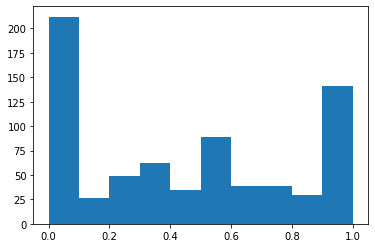

In [139]:
plt.hist(osha['prob_detection'])

### Logit transform of response probabilities

In [140]:
probs = osha['prob_detection']
probs = np.where(probs == 0, probs+0.01, probs)
probs = np.where(probs == 1, probs-0.01, probs)
osha['logit_prob'] = logit(probs)

(array([198.,   3.,  17.,  58., 107., 129.,  61.,   9.,   1., 138.]),
 array([-4.73619845, -3.80306662, -2.86993479, -1.93680296, -1.00367113,
        -0.0705393 ,  0.86259253,  1.79572436,  2.72885619,  3.66198802,
         4.59511985]),
 <a list of 10 Patch objects>)

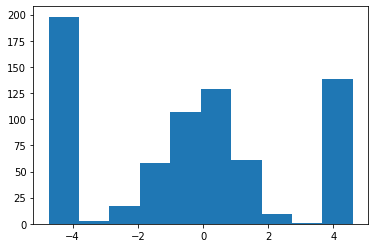

In [141]:
plt.hist(osha['logit_prob'])

### Filter out features that never occur in our chemical dataset 

In [142]:
from sklearn.feature_selection import VarianceThreshold
osha = osha.loc[:, (osha ).any(axis=0)].copy()

### Split into a test and training dataset

In [143]:
y = osha.logit_prob
x = osha.drop(['prob_detection', 'logit_prob','preferred_name'],axis=1)
x_train_all,x_test_all,y_train_all,y_test_all=train_test_split(x,y,test_size=0.2, random_state = 2344)

# filter out low variance features, but keep full features as x_f for comparison
from sklearn.feature_selection import VarianceThreshold
var_filter = VarianceThreshold(threshold=0.1)
var_filter.fit(x)
x_f = x.loc[:,var_filter.get_support()]
x_train,x_test,y_train,y_test=train_test_split(x_f,y,test_size=0.2, random_state=234)

feature_list = list(x_f.columns)
feature_list_all = list(x.columns)

### Shape of full dataset

In [144]:
print('Training Features Shape:', x_train_all.shape)
print('Training Labels Shape:', y_train_all.shape)
print('Testing Features Shape:', x_test_all.shape)
print('Testing Labels Shape:', y_test_all.shape)

Training Features Shape: (576, 393)
Training Labels Shape: (576,)
Testing Features Shape: (145, 393)
Testing Labels Shape: (145,)


### Linear regression for a quick baseline

In [176]:
lm = LinearRegression().fit(x_train_all, y_train_all)
lm.score(x_train_all, y_train_all)

0.576613064880834

In [178]:
lm.score(x_test_all, y_test_all)

-1.449902603501863

In [147]:
def plot_fit(predicted, y):
    fig, ax = plt.subplots()
    ax.scatter(y, predicted)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    ax.set_xlabel('Measured log odds of detection')
    ax.set_ylabel('Predicted log odds of detection')
    plt.show()

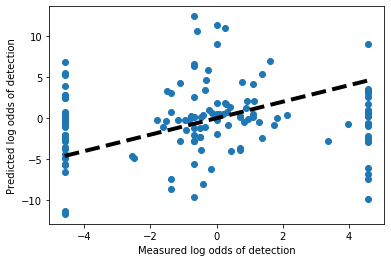

In [148]:
predictions = lm.predict(x_test_all)
plot_fit(predictions, y_test_all)

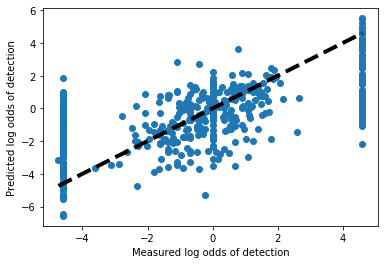

In [181]:
predictions = lm.predict(x_train_all)
plot_fit(predictions, y_train_all)

### Lasso regression for automated feature selection

In [149]:
lassocv = LassoCV(cv=5,random_state=11).fit(x_train_all, y_train_all)
lassocv.score(x_train_all, y_train_all)

0.0023404266632059967

In [150]:
lassocv.score(x_test_all, y_test_all)

-0.0019768970078040127

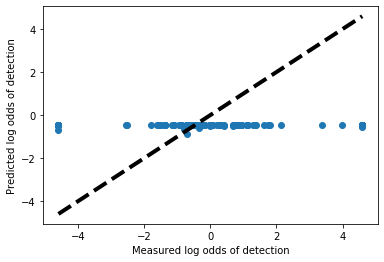

In [151]:
predictions = lassocv.predict(x_test_all)
plot_fit(predictions, y_test_all)

In [152]:
[(feature_list_all[i], coef) for i, coef in enumerate(lassocv.coef_) if (~np.isclose(coef,0))]

[('soil_adsorption_coefficient_koc_l/kg_opera_pred', -9.619696087094461e-07)]

### Random Forest Regressor

In [153]:
param_grid = {'n_estimators': [1500, 3000, 4500, 6000, 7500]}
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, n_jobs=30)
grid_rf.fit(x_train_all, y_train_all)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=30,
             param_grid={'n_estimators': [1500, 3000, 4500

In [154]:
grid_rf.best_params_

{'n_estimators': 6000}

In [155]:
best_rf = grid_rf.best_estimator_
predictions = best_rf.predict(x_test_all)
errors = abs(predictions - y_test_all)
print('Mean Absolute Error:', round(np.mean(errors), 2), '')
print('R2:', r2_score(y_test_all, predictions))

Mean Absolute Error: 2.33 
R2: 0.10193212564959253


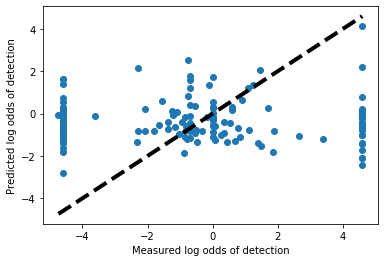

In [156]:
plot_fit(predictions, y_test)

In [157]:
feature_importances = pd.DataFrame(best_rf.feature_importances_,
                                   index = feature_list_all,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.head(20)

,importance
melting_point_degc_opera_pred,0.082120
biodegradation_half_life_days_days_opera_pred,0.073718
monoisotopic_mass,0.068485
opera_km_days_opera_pred,0.060247
bioconcentration_factor_opera_pred,0.057913
soil_adsorption_coefficient_koc_l/kg_opera_pred,0.055174
water_solubility_mol/l_opera_pred,0.054295
octanol_air_partition_coeff_logkoa_opera_pred,0.052540
octanol_water_partition_logp_opera_pred,0.051268
boiling_point_degc_opera_pred,0.046699


### Let's try a multi-layer perceptron for fun

In [158]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train_all)
StandardScaler(copy=True, with_mean=True, with_std=True)
x_train_scaled = scaler.transform(x_train_all)
x_test_scaled = scaler.transform(x_test_all)

In [171]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(activation='relu',hidden_layer_sizes=(400,200),max_iter=10000, learning_rate='adaptive', verbose=False)
mlp.fit(x_train_scaled,y_train_all)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(400, 200), learning_rate='adaptive',
             learning_rate_init=0.001, max_iter=10000, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [172]:
mlp.score(x_test_scaled,y_test_all) # r2

-0.24730152674578165

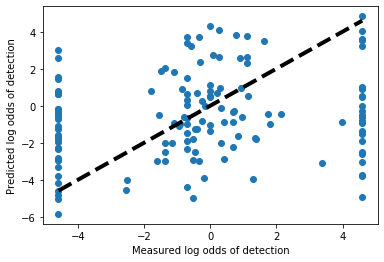

In [173]:
predictions = mlp.predict(x_test_scaled)
plot_fit(predictions,y_test_all)